In [1]:
import torch 
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision.models import resnet50
import numpy as np
import torch.nn.functional as F

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((255, 255)),
                              ])
train_set = datasets.ImageFolder(root='C:\\Users\\abassoma\\Documents\\Dataset\\Indonesian_dataset\\indonesian_train_dataset',transform=transform)
val_set = datasets.ImageFolder(root='C:\\Users\\abassoma\\Documents\\Dataset\\Indonesian_dataset\\indonesian_test_dataset',transform=transform)
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set,batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(val_set,batch_size,shuffle=False)

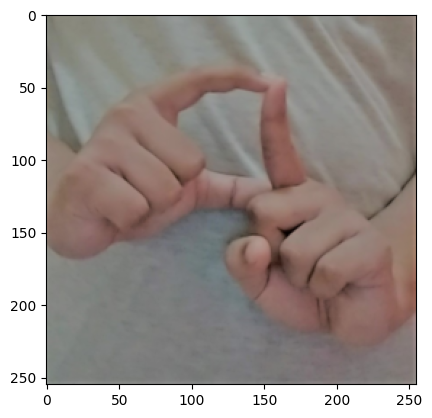

In [3]:
def showImage(img):
    img = np.array(img)
    img = img.transpose(1,2,0)
    plt.imshow(img)

x = next(iter((train_loader)))[0][2]
showImage(x)

t5= transforms.RandomAffine(
    degrees=0,  
    translate=(0.5, 0))
x4= t5(x)

#### Training resnet50 with all the 8*26 observations

In [4]:
model2 = resnet50(pretrained=True)
num_feature = model2.fc.in_features
model2.fc = nn.Linear(num_feature,26)

for param in model2.parameters():
    param.requires_grad = False

for param in model2.fc.parameters():
    param.requires_grad = True

c:\Users\abassoma\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\abassoma\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
import lightning as L
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics as TM
import torch.nn.functional as F

class Module(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = model2
        # Définir la loss function
        self.criterion = nn.CrossEntropyLoss()
        
        num_classes = 26
        # Définir les métriques
        self.train_acc = TM.Accuracy(task='multiclass', num_classes=num_classes)
        self.train_top3 = TM.Accuracy(task='multiclass', num_classes=num_classes, top_k=3)
        
        self.val_acc = TM.Accuracy(task='multiclass', num_classes=num_classes)
        self.val_top3 = TM.Accuracy(task='multiclass', num_classes=num_classes, top_k=3)
        self.val_recall = TM.Recall(task='multiclass', num_classes=num_classes)

    def training_step(self, batch, batch_idx):
        images, targets = batch
        logits = self.model(images)
        loss = self.criterion(logits, targets)
        preds = torch.argmax(logits, dim=-1)
        self.train_acc(preds, targets)
        self.log('train_loss', loss, on_step=True, on_epoch=True)
        self.log('train_acc', self.train_acc, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        logits = self.model(images)
        loss = self.criterion(logits, targets)
        preds = torch.argmax(logits, dim=-1)
        self.val_acc(preds, targets)
        self.val_recall(preds, targets)  
        self.log('val_loss', loss, on_step=True, on_epoch=True)
        self.log('val_acc', self.val_acc, on_step=True, on_epoch=True)
        self.log('val_recall', self.val_recall, on_step=True, on_epoch=True)

    def configure_optimizers(self):
        # Optimiser uniquement les paramètres du classifieur (la dernière couche)
        return optim.SGD(self.model.parameters(), lr=0.001, momentum=0.9)


In [6]:
# my_module = Module()
# trainer = L.Trainer(max_epochs=45)
# trainer.fit(
#     my_module,
#     train_loader,
#     test_loader
# )

#### Use 8**26 observations to Train the SIMCLR Algorithm and use 5*26 for the fine tuning on the classification head

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),

    transforms.Resize((255, 255))  
])

train_set = datasets.ImageFolder(root='C:\\Users\\abassoma\\Documents\\Dataset\\Indonesian_dataset\\indonesian_train_1',transform=transform)
val_set = datasets.ImageFolder(root='C:\\Users\\abassoma\\Documents\\Dataset\\Indonesian_dataset\\indonesian_train_2',transform=transform)
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set,batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(val_set,batch_size,shuffle=True)

#### Evaluate the model perfomence with several transformations one by one 

In [8]:

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import random

transformation_groups = {
    "translations": [
        transforms.RandomAffine(degrees=0, translate=(0.1, 0)),  # Translation de 10%
        transforms.RandomAffine(degrees=0, translate=(0.2, 0)),  
        transforms.RandomAffine(degrees=0, translate=(0.3, 0)),  
        transforms.RandomAffine(degrees=0, translate=(0.4, 0)),  
        transforms.RandomAffine(degrees=0, translate=(0.5, 0)),  
        transforms.RandomAffine(degrees=0, translate=(0.6, 0)),  
        transforms.RandomAffine(degrees=0, translate=(0.7, 0)),  
        transforms.RandomAffine(degrees=0, translate=(0.8, 0))   
    ],
    "rotations": [
        transforms.RandomAffine(degrees=10, translate=(0, 0)),  # Rotation de 10°
        transforms.RandomAffine(degrees=20, translate=(0, 0)),  
        transforms.RandomAffine(degrees=30, translate=(0, 0)),  
        transforms.RandomAffine(degrees=40, translate=(0, 0)),  
        transforms.RandomAffine(degrees=50, translate=(0, 0)),  
        transforms.RandomAffine(degrees=60, translate=(0, 0)),  
        transforms.RandomAffine(degrees=70, translate=(0, 0)),  
        transforms.RandomAffine(degrees=80, translate=(0, 0))   
    ],
    "ResizedCrop": [
        transforms.RandomResizedCrop(size=128, scale=(0.8, 1.0)),  # Découpe aléatoire redimensionnée
        transforms.RandomResizedCrop(size=64, scale=(0.5, 1.0)),   
        transforms.RandomResizedCrop(size=256, scale=(0.5, 1.0)),  
        transforms.RandomResizedCrop(size=128, scale=(0.6, 0.9)),  
        transforms.RandomResizedCrop(size=128, scale=(0.7, 1.0)),  
        transforms.RandomResizedCrop(size=128, scale=(0.3, 0.7)),  
        transforms.RandomResizedCrop(size=192, scale=(0.5, 1.0)),  
        transforms.RandomResizedCrop(size=32, scale=(0.5, 1.0))    
    ],
    "ColorJitter": [
        transforms.ColorJitter(brightness=0.5),  # Variation de luminosité
        transforms.ColorJitter(contrast=0.5),   
        transforms.ColorJitter(saturation=0.5),  
        transforms.ColorJitter(hue=0.3),        
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  
        transforms.ColorJitter(saturation=0.3, hue=0.1),        
        transforms.ColorJitter(brightness=0.4, saturation=0.4), 
        transforms.ColorJitter(contrast=0.4, hue=0.2)           
    ],
    "GaussianBlur": [
        transforms.GaussianBlur(kernel_size=(3, 1), sigma=(0.1, 5)),  # Flou gaussien                                                         
        transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2)),  
        transforms.GaussianBlur(kernel_size=(1, 1), sigma=(0.1, 3)),  
        transforms.GaussianBlur(kernel_size=(1, 3), sigma=(0.1, 4)),  
        transforms.GaussianBlur(kernel_size=(3, 1), sigma=(0.5, 1)),  
        transforms.GaussianBlur(kernel_size=(3, 1), sigma=(0.2, 0.8)),  
        transforms.GaussianBlur(kernel_size=(3, 1), sigma=(0.2, 1)),  
        transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.3, 2))                            
    ],
    "RandomErasing": [
        transforms.RandomErasing(p=0.3, scale=(0.02, 0.33), ratio=(0.3, 3.3)),  # Effacement aléatoire
        transforms.RandomErasing(p=0.4, scale=(0.1, 0.2), ratio=(0.3, 3.3)),   
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.3), ratio=(0.3, 3.3)),   
        transforms.RandomErasing(p=0.2, scale=(0.01, 0.2), ratio=(0.5, 1.5)),  
        transforms.RandomErasing(p=0.3, scale=(0.05, 0.25), ratio=(0.4, 2.5)),  
        transforms.RandomErasing(p=0.3, scale=(0.02, 0.2), ratio=(0.2, 1.5)),   
        transforms.RandomErasing(p=0.4, scale=(0.03, 0.3), ratio=(0.4, 1.5)),   
        transforms.RandomErasing(p=0.3, scale=(0.01, 0.15), ratio=(0.2, 1.0))   
    ],
    "RandomHorizontalFlip": [
        transforms.RandomHorizontalFlip(p=0.5),  # Inversion horizontale
        transforms.RandomHorizontalFlip(p=0.7),  
        transforms.RandomHorizontalFlip(p=0.3),  
        transforms.RandomHorizontalFlip(p=0.9),  
        transforms.RandomHorizontalFlip(p=0.2),
        transforms.RandomHorizontalFlip(p=0.6),  
        transforms.RandomHorizontalFlip(p=0.4),  
        transforms.RandomHorizontalFlip(p=0.8)   
    ],
    "RandomVerticalFlip": [
        transforms.RandomVerticalFlip(p=0.5),    # Inversion verticale
        transforms.RandomVerticalFlip(p=0.7),    
        transforms.RandomVerticalFlip(p=0.3),    
        transforms.RandomVerticalFlip(p=0.9),   
        transforms.RandomVerticalFlip(p=0.2),    
        transforms.RandomVerticalFlip(p=0.6),    
        transforms.RandomVerticalFlip(p=0.4),    
        transforms.RandomVerticalFlip(p=0.8)      
    ],
    "others": [
        transforms.RandomRotation(degrees=30),    # Rotation aléatoire
        transforms.RandomHorizontalFlip(p=0.7),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  
        transforms.ColorJitter(brightness=0.2),  
        transforms.RandomAffine(degrees=0, translate=(0.1, 0)),  
        transforms.RandomGrayscale(p=0.2),       
        transforms.RandomAffine(degrees=10),     
        transforms.RandomAffine(degrees=20)       
    ],
    "Bad_Mixed" : [
        transforms.ColorJitter(brightness=0.82, contrast=0.72),  
        transforms.RandomErasing(p=0.4, scale=(0.1, 0.2), ratio=(0.3, 3.3)),
        transforms.RandomGrayscale(p=0.2),  
        transforms.GaussianBlur(kernel_size=(9, 9), sigma=(0.1, 4)),  
        transforms.ColorJitter(brightness=0.2, contrast=0.82),  
        transforms.ColorJitter(brightness=0.72, contrast=0.2),   
        transforms.ColorJitter(brightness=0.82, contrast=0.52),
        transforms.GaussianBlur(kernel_size=(9, 9), sigma=(0.1, 4)),  
    ]
}

# Sélectionner les groupes de transformations à utiliser
def get_transformations(active_groups):
    selected_transformations = []
    for group in active_groups:
        selected_transformations.extend(transformation_groups[group])
    return selected_transformations

In [9]:
import random
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.models.detection import maskrcnn_resnet50_fpn
from PIL import Image 

# Charger le modèle pré-entraîné Mask R-CNN
netwk = maskrcnn_resnet50_fpn(pretrained=True)

# Fonction pour choisir une transformation aléatoire parmi les groupes sélectionnés
def random_choose(transformation_list):
    p = random.randint(0, len(transformation_list) - 1)
    return transformation_list[p]


# Générer deux batchs d'images transformées en fonction des transformations actives
def generate_batch(batch_image, active_groups):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    netwk.to(device)
    netwk.eval()
    
    batch_image = batch_image.to(device)
    selected_transformations = get_transformations(active_groups)
    transform_batch_1 = random_choose(selected_transformations)
    transform_batch_2 = random_choose(selected_transformations)

    first_batch = []
    second_batch = []
    
    with torch.no_grad():
        prediction_mask = netwk(batch_image)

    batch_image = batch_image.cpu().numpy()
   
    for index, image in enumerate(batch_image):
        boxes = prediction_mask[index]['boxes'].cpu().numpy()
        masks = prediction_mask[index]['masks'].cpu().numpy()
        scores = prediction_mask[index]['scores'].cpu().numpy()

        # Initialise les images transformées avec les images originales
        image_permuted = image.transpose(1, 2, 0)
        image_permuted_1 = image_permuted.copy()
        image_permuted_2 = image_permuted.copy()

        transformation_applied = False  # Nouveau flag pour suivre les transformations

        for i, box in enumerate(boxes):
            if scores[i] > 0.2:
                x1, y1, x2, y2 = box.astype(int)
                mask = masks[i, 0] > 0.2
                
                colored_object = image_permuted[y1:y2, x1:x2].copy()
                colored_object = Image.fromarray((colored_object * 255).astype(np.uint8), mode='RGB')

                # Appliquer les transformations
                colored_object_transformed_1 = transform_batch_1(colored_object)
                colored_object_transformed_2 = transform_batch_2(colored_object)

                # Convertir en tableau numpy et normaliser
                colored_object_transformed_1 = np.array(colored_object_transformed_1) / 255.0
                colored_object_transformed_2 = np.array(colored_object_transformed_2) / 255.0

                mask_resized = mask[y1:y2, x1:x2]
                mask_resized = np.expand_dims(mask_resized, axis=-1)
                mask_resized = np.repeat(mask_resized, 3, axis=-1)

                image_permuted_1[y1:y2, x1:x2][mask_resized] = colored_object_transformed_1[mask_resized]
                image_permuted_2[y1:y2, x1:x2][mask_resized] = colored_object_transformed_2[mask_resized]
                
                transformation_applied = True  # Marque la transformation

        # Si aucune transformation n'a été appliquée, on conserve l'image originale
        if not transformation_applied:
            image_permuted_1 = transform_batch_1(image_permuted)
            image_permuted_2 = transform_batch_1(image_permuted)

        # Convertir en format batchable
        image_to_save_1 = image_permuted_1.transpose(2, 0, 1)
        image_to_save_2 = image_permuted_2.transpose(2, 0, 1)

        first_batch.append(image_to_save_1)
        second_batch.append(image_to_save_2)

    first_batch = np.array(first_batch)
    second_batch = np.array(second_batch)
    
    first_batch = torch.from_numpy(first_batch).float().to(device)
    second_batch = torch.from_numpy(second_batch).float().to(device)
    
    return first_batch, second_batch

test = next(iter(train_loader))[0]


c:\Users\abassoma\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\abassoma\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
from lightly.loss import NTXentLoss

In [11]:
backbone = resnet50(pretrained=True).to('cuda')

class HeadProjection(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1000, 200)
        self.fc2 = nn.Linear(200,29)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

Projection = HeadProjection()

class SIMCLR(nn.Module):
    def __init__(self,backbone,projection):
        super().__init__()
        self.backbone = backbone
        self.projection = Projection
    
    def forward(self,x):
        x=self.projection(self.backbone(x))
        return x
simclr_model = SIMCLR(backbone,Projection).to('cuda')

c:\Users\abassoma\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\abassoma\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Début de l'époque 1
Début de l'époque 2
Début de l'époque 3
Début de l'époque 4
Début de l'époque 5
Début de l'époque 6
Début de l'époque 7
Début de l'époque 8
Début de l'époque 9
Début de l'époque 10
Début de l'époque 11
Début de l'époque 12
Début de l'époque 13
Début de l'époque 14
Début de l'époque 15
Début de l'époque 16
Début de l'époque 17
Début de l'époque 18
Début de l'époque 19
Début de l'époque 20
Début de l'époque 21
Début de l'époque 22
Début de l'époque 23
Début de l'époque 24
Début de l'époque 25
Début de l'époque 26
Début de l'époque 27
Début de l'époque 28
Début de l'époque 29
Début de l'époque 30
Début de l'époque 31
Début de l'époque 32
Début de l'époque 33
Début de l'époque 34
Début de l'époque 35
Début de l'époque 36
Début de l'époque 37
Début de l'époque 38
Début de l'époque 39
Début de l'époque 40
Début de l'époque 41
Début de l'époque 42
Début de l'époque 43
Début de l'époque 44
Début de l'époque 45
Début de l'époque 46
Début de l'époque 47
Début de l'époque 48
D

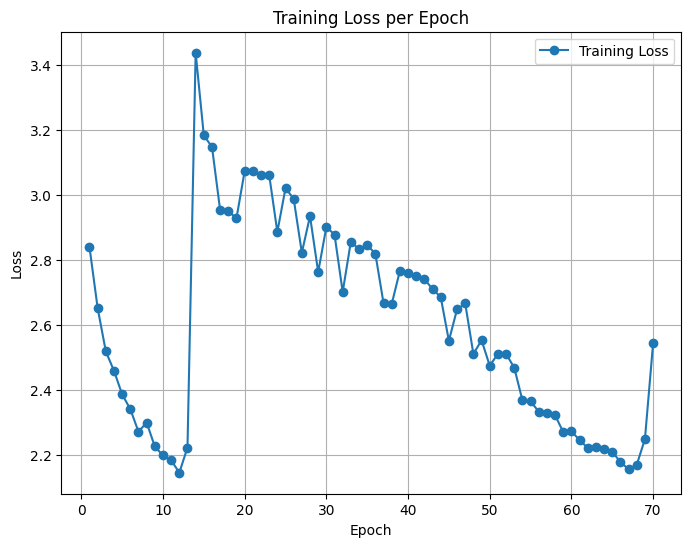

In [12]:
import matplotlib.pyplot as plt
from pytorch_metric_learning import losses
import torch.optim as optim
criterion = NTXentLoss()
optimizer = optim.SGD(simclr_model.parameters(), lr=0.001)

def training(train_loader, test_loader, num_epochs, active_groups):
    epoch_losses = [] 
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        print(f"Début de l'époque {epoch + 1}")
        
        for step, (data, label) in enumerate(train_loader):
            optimizer.zero_grad()
            data = data.to('cuda')
            # Générer les deux batchs avec les groupes de transformations activés
            batch_1, batch_2 = generate_batch(data, active_groups)
            batch_1, batch_2 = batch_1.to('cuda'), batch_2.to('cuda')
            embedding_batch_1 = simclr_model(batch_1)
            embedding_batch_2 = simclr_model(batch_2)
            loss = criterion(embedding_batch_1,embedding_batch_2)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_losses.append(epoch_loss)
    
    # Plot des erreurs d'entraînement
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss per Epoch')
    plt.grid(True)
    plt.legend()
    plt.savefig('Training_loss_simclr_others_essai_4.png')
    plt.show()

# Exemple d'appel de la fonction avec les groupes actifs
training(train_loader, test_loader, 70, active_groups=["GaussianBlur"])


### Finetune the model and just train the classification head with 3**26 observations

In [13]:
netwk = simclr_model.backbone
num_ftrs = netwk.fc.in_features 
print(num_ftrs)
netwk.fc = nn.Linear(num_ftrs,26)

# Geler toutes les couches du modèle SimCLR pré-entraîné
for param in netwk.parameters():
    param.requires_grad = False

# Débloquer uniquement la dernière couche fully connected (fc)
for param in netwk.fc.parameters():
    param.requires_grad = True


2048


In [14]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((224, 224)),
                               transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
train_set = datasets.ImageFolder(root='C:\\Users\\abassoma\\Documents\\Dataset\\Indonesian_dataset\\indonesian_train_2',transform=transform)
val_set = datasets.ImageFolder(root='C:\\Users\\abassoma\\Documents\\Dataset\\Indonesian_dataset\\indonesian_test_dataset',transform=transform)
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set,batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(val_set,batch_size,shuffle=False)

In [15]:
import lightning as L
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics as TM
import torch.nn.functional as F

class Module(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = netwk
        # Définir la loss function
        self.criterion = nn.CrossEntropyLoss()
        
        num_classes = 26
        # Définir les métriques
        self.train_acc = TM.Accuracy(task='multiclass', num_classes=num_classes)
        self.train_top3 = TM.Accuracy(task='multiclass', num_classes=num_classes, top_k=3)
        
        self.val_acc = TM.Accuracy(task='multiclass', num_classes=num_classes)
        self.val_top3 = TM.Accuracy(task='multiclass', num_classes=num_classes, top_k=3)
        self.val_recall = TM.Recall(task='multiclass', num_classes=num_classes)

    def training_step(self, batch, batch_idx):
        images, targets = batch
        logits = self.model(images)
        loss = self.criterion(logits, targets)
        preds = torch.argmax(logits, dim=-1)
        self.train_acc(preds, targets)
        self.log('train_loss', loss, on_step=True, on_epoch=True)
        self.log('train_acc', self.train_acc, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        logits = self.model(images)
        loss = self.criterion(logits, targets)
        preds = torch.argmax(logits, dim=-1)
        self.val_acc(preds, targets)
        self.val_recall(preds, targets)  
        self.log('val_loss', loss, on_step=True, on_epoch=True)
        self.log('val_acc', self.val_acc, on_step=True, on_epoch=True)
        self.log('val_recall', self.val_recall, on_step=True, on_epoch=True)

    def configure_optimizers(self):

        return optim.SGD(self.model.parameters(), lr=0.001, momentum=0.9)


In [16]:
my_module = Module()
trainer = L.Trainer(max_epochs=70)
trainer.fit(
    my_module,
    train_loader, 
    test_loader
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params | Mode 
----------------------------------------------------------
0 | model      | ResNet             | 23.6 M | train
1 | criterion  | CrossEntropyLoss   | 0      | train
2 | train_acc  | MulticlassAccuracy | 0      | train
3 | train_top3 | MulticlassAccuracy | 0      | train
4 | val_acc    | MulticlassAccuracy | 0      | train
5 | val_top3   | MulticlassAccuracy | 0      | train
6 | val_recall | MulticlassRecall   | 0      | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\abassoma\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


c:\Users\abassoma\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\abassoma\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 69: 100%|██████████| 3/3 [00:07<00:00,  0.42it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=70` reached.


Epoch 69: 100%|██████████| 3/3 [00:07<00:00,  0.40it/s, v_num=1]
